In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import seaborn as sns
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier


Using TensorFlow backend.


In [2]:
data = pd.read_csv('../data/SalesForce_Contact.csv',encoding="ISO-8859-1")
df = pd.DataFrame(data)


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,19,25,27,32,33,34,35,36,37,38,41,42,45,46,52,53,57,58,59,60,61,62,63,66,67,70,71,73,74,75,76,78,80,82,83,88,89,90,93,96,108,109,114,115,116,117,118,120,122,124,127,129,130,133,136,137,140,141,144,146,150,154,155,158,159,162,163,164,170,171,172,173,184,186,188,194,195,200,204,208,212,220,222,227,231,233,234,235,237,238,240,243,244,247,254,260,261,262,270,273,274,275,280,284,285,288,291,293,294,295,297,299,301,304,307,309,310,313,314,315,316,317,318,319,322,324,325,329,332,338,339,340,342,344,345,347,357,359,360,361,362,363,370,371,372,373,374,375,377,378,380,382,383,385,386,387,388) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df)

132445

In [4]:
# parse old df so that entries have valid target fields

new_df = df.dropna(subset =['Confirmed_Hired_Date__c', 'CreatedDate'])
new_df = new_df.reset_index().drop('index', axis = 1)
new_df['Confirmed_Hired_Date__c'] = new_df['Confirmed_Hired_Date__c'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y %H:%M'))
new_df['CreatedDate'] = new_df['CreatedDate'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y %H:%M'))
new_df = new_df[(new_df['Confirmed_Hired_Date__c'] > datetime.strptime("01/01/1700",'%m/%d/%Y'))
                &(new_df['Confirmed_Hired_Date__c'] < datetime.strptime("05/01/2019",'%m/%d/%Y'))]
new_df = new_df[(new_df['CreatedDate'] > datetime.strptime("01/01/1700",'%m/%d/%Y'))
                &(new_df['CreatedDate'] < datetime.strptime("05/01/2019",'%m/%d/%Y'))]
new_df = new_df.dropna(subset =['Virtual_Workshop_Participant__c', 
                          'VCF_Participant__c', 'Used_Volunteer_Services__c', 'Resume_Tailoring_Tips__c',
                          'Used_Federal_Services__c', 'Interview_Skills__c', 'Value_Proposition__c', 
                          'On_Job_Board__c'])
new_df = new_df.reset_index().drop('index', axis = 1)


In [5]:
len(new_df)

27148

In [6]:
# get median resume completion time for entries who do not have it
resume_time = []
for _,x in new_df.iterrows():
    try:
        a = datetime.strptime(str(x['Date_Resume_Completed__c']), '%m/%d/%Y %H:%M')
        if (a > datetime.strptime("01/01/1700",'%m/%d/%Y') and a < datetime.strptime("05/01/2019",'%m/%d/%Y')):
            resume_time.append((a-x['CreatedDate']).days)
    except:
        continue
        
med_resume_complete_time = np.median(resume_time)


In [7]:
# get median assessment completion time for entries who do not have it
assessment_time = []
for _,x in new_df.iterrows():
    try:
        a = datetime.strptime(str(x['Dat_Initial_Assessment_was_Completed__c']), '%m/%d/%Y %H:%M')
        if (a > datetime.strptime("01/01/1700",'%m/%d/%Y') and a < datetime.strptime("05/01/2019",'%m/%d/%Y')):
            assessment_time.append((a-x['CreatedDate']).days)
    except:
        continue
        
med_assess_complete_time = np.median(assessment_time)


In [8]:

raw_resume = []
raw_assessment = []

for _,x in new_df.iterrows():
    # time to complete a resume
    try:
        b = datetime.strptime(str(x['Date_Resume_Completed__c']), '%m/%d/%Y %H:%M')
        raw_resume.append((b-x['CreatedDate']).days)
    except:
        raw_resume.append(med_resume_complete_time)
    # time to complete an assessment
    try:
        c = datetime.strptime(str(x['Dat_Initial_Assessment_was_Completed__c']), '%m/%d/%Y %H:%M')
        raw_assessment.append((c-x['CreatedDate']).days)
    except:
        raw_assessment.append(med_assess_complete_time)

In [9]:
Y=[]
X=[]
for index,x in new_df.iterrows():
    feature = []
    feature.append(raw_resume[index])
    feature.append(raw_assessment[index])
    feature.append(x['Virtual_Workshop_Participant__c'])
    feature.append(x['VCF_Participant__c'])
    feature.append(x['Used_Volunteer_Services__c'])
    feature.append(x['Resume_Tailoring_Tips__c'])
    feature.append(x['Used_Federal_Services__c'])
    feature.append(x['Value_Proposition__c'])
    feature.append(x['Interview_Skills__c'])
    feature.append(x['On_Job_Board__c'])
    X.append(feature)   
    Y.append((x['Confirmed_Hired_Date__c']-x['CreatedDate']).days//30+1)
    

In [10]:
# try 1: 7-dims (didn't perform well)

result_df = pd.DataFrame()
result_df['Highest_Level_of_Education_Completed__c'] = new_df['Highest_Level_of_Education_Completed__c']
result_df['Service_Rank__c'] = new_df['Service_Rank__c']
result_df['MyTrak_Spouse_is_Employed__c'] = new_df['MyTrak_Spouse_is_Employed__c']
result_df['Gender__c'] = new_df['Gender__c']
result_df['Race__c'] = new_df['Race__c']
result_df['Status__c'] = new_df['Status__c']
result_df['Service_Branch__c'] = new_df['Service_Branch__c']


In [11]:
# dummies for placeholder training data

dummy_df  = pd.get_dummies(result_df)
dummy_array = np.array(dummy_df)
X_array = np.array(X)
new_X = np.hstack((dummy_array,X_array))


In [12]:
# split train/test data

X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.01)
X_train=normalize(X_train)
X_test=normalize(X_test)


In [13]:
# try 2: make Linear SVR: MSE too high

regr=LinearSVR(max_iter = 20000, tol=1e-6)
regr.fit(X_train, y_train)
y_predict=regr.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_predict))


MSE: 59.796935483287605


In [14]:
# customized accuracy function base on months different

time_diff=[]
for i in range(len(y_predict)):
    time_diff.append(abs(y_test[i] - y_predict[i]))

def accuracy(threshold):
    accurate = 0
    for i in time_diff:
        if (i <= threshold):
            accurate += 1
    return accurate/len(time_diff)    


In [15]:
# try 3: 86-dims with almost all useful fields

mean = np.mean(regr.coef_)
large = np.max(regr.coef_) - np.min(regr.coef_)
coeff = [(x - mean) / large for x in regr.coef_]
features = list(dummy_df.columns)
features.append('resume')
features.append('assessment')
features.extend(['Virtual_Workshop_Participant__c', 
                          'VCF_Participant__c', 'Used_Volunteer_Services__c', 'Resume_Tailoring_Tips__c',
                          'Used_Federal_Services__c', 'Value_Proposition__c','Interview_Skills__c',
                          'On_Job_Board__c'])


In [16]:
len(features)

86

In [17]:
# print fields with the highest coeff

print("fields with the highest absolute coeff:")
l = [(coeff[i]*100,features[i]) for i in range(len(coeff))]
l = sorted(l, key=lambda x:-abs(x[0]))
for entry in l[:15]:
    print(entry)


fields with the highest absolute coeff:
(-59.266891660859415, 'Race__c_White')
(40.7331083391406, 'Resume_Tailoring_Tips__c')
(-36.17699836944524, 'Race__c_Black or African American')
(-33.70921786315401, 'Race__c_Hispanic or Latino')
(-23.527280731602488, 'Status__c_Unemployed')
(19.843294600458062, 'Used_Federal_Services__c')
(-17.315514424599137, 'MyTrak_Spouse_is_Employed__c')
(-15.4342863639448, 'Status__c_Under employed - Insufficient income')
(-15.292043233956665, 'Race__c_Two or more races')
(14.975442380653325, 'Status__c_Active Duty')
(-14.692687975093627, 'Highest_Level_of_Education_Completed__c_High School/GED')
(-14.613222930714462, 'Race__c_Asian or Pacific Islander')
(14.490132909215497, 'Used_Volunteer_Services__c')
(-13.754449062289162, 'Status__c_Employed')
(13.588232747922369, 'VCF_Participant__c')


In [18]:
c = 0
for y in Y:
    if y >= 12: c +=1
print("% of people taking more than a year to find jobs:", c/len(Y)*100)

% of people taking more than a year to find jobs: 21.81007809046707


In [19]:
# filter outliers (those who takes 2 years+ to find jobs) -> unemployed

filtered_data = [list(new_X[i])+[Y[i]] for i in range(len(new_X))]
filtered_data = [x for x in filtered_data if x[-1] >= 0 and x[-1] <= 22]
filtered_x = np.array([x[:-1] for x in filtered_data])
filtered_y = [x[-1] for x in filtered_data]


In [20]:
print("unemployed:", len(Y) - len(filtered_y))

unemployed: 1331


In [21]:
# try 3 cont. : train LinearSVR 100 times and take average accuracy

avg_acc = dict()
mse = []
for run in range(100):
    X_train, X_test, y_train, y_test = train_test_split(filtered_x, filtered_y, test_size=0.01)
    X_train=normalize(X_train)
    X_test=normalize(X_test)

    regr=LinearSVR(max_iter = 100000, tol=1e-6)
    regr.fit(X_train, y_train)

    y_predict=regr.predict(X_test)

    mse.append(mean_squared_error(y_test, y_predict))

    time_diff=[]
    for i in range(len(y_predict)):
        time_diff.append(abs(y_test[i] - round(y_predict[i])))

    for i in range(24):
        if i not in avg_acc: avg_acc[i] = [accuracy(i)]
        else:avg_acc[i].append(accuracy(i)) 
            

In [22]:
print("LinearSVR accuracy:")
for k,v in avg_acc.items():
    if 0 < k <= 12:
        print("month range:", k, " prediction accuracy:", str(round(sum(v)/len(v)*100, 3))+"%")
        

LinearSVR accuracy:
month range: 1  prediction accuracy: 28.861%
month range: 2  prediction accuracy: 47.344%
month range: 3  prediction accuracy: 64.042%
month range: 4  prediction accuracy: 75.459%
month range: 5  prediction accuracy: 81.703%
month range: 6  prediction accuracy: 85.591%
month range: 7  prediction accuracy: 88.459%
month range: 8  prediction accuracy: 90.66%
month range: 9  prediction accuracy: 92.575%
month range: 10  prediction accuracy: 94.162%
month range: 11  prediction accuracy: 95.676%
month range: 12  prediction accuracy: 96.691%


In [24]:
# set seaborn params
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(30,25)})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   
sns.set(font_scale=5)


In [25]:
y_plt = [x for x in Y if x >= 0 and x <= 24]

Text(0.5, 0, 'Months till Hired')

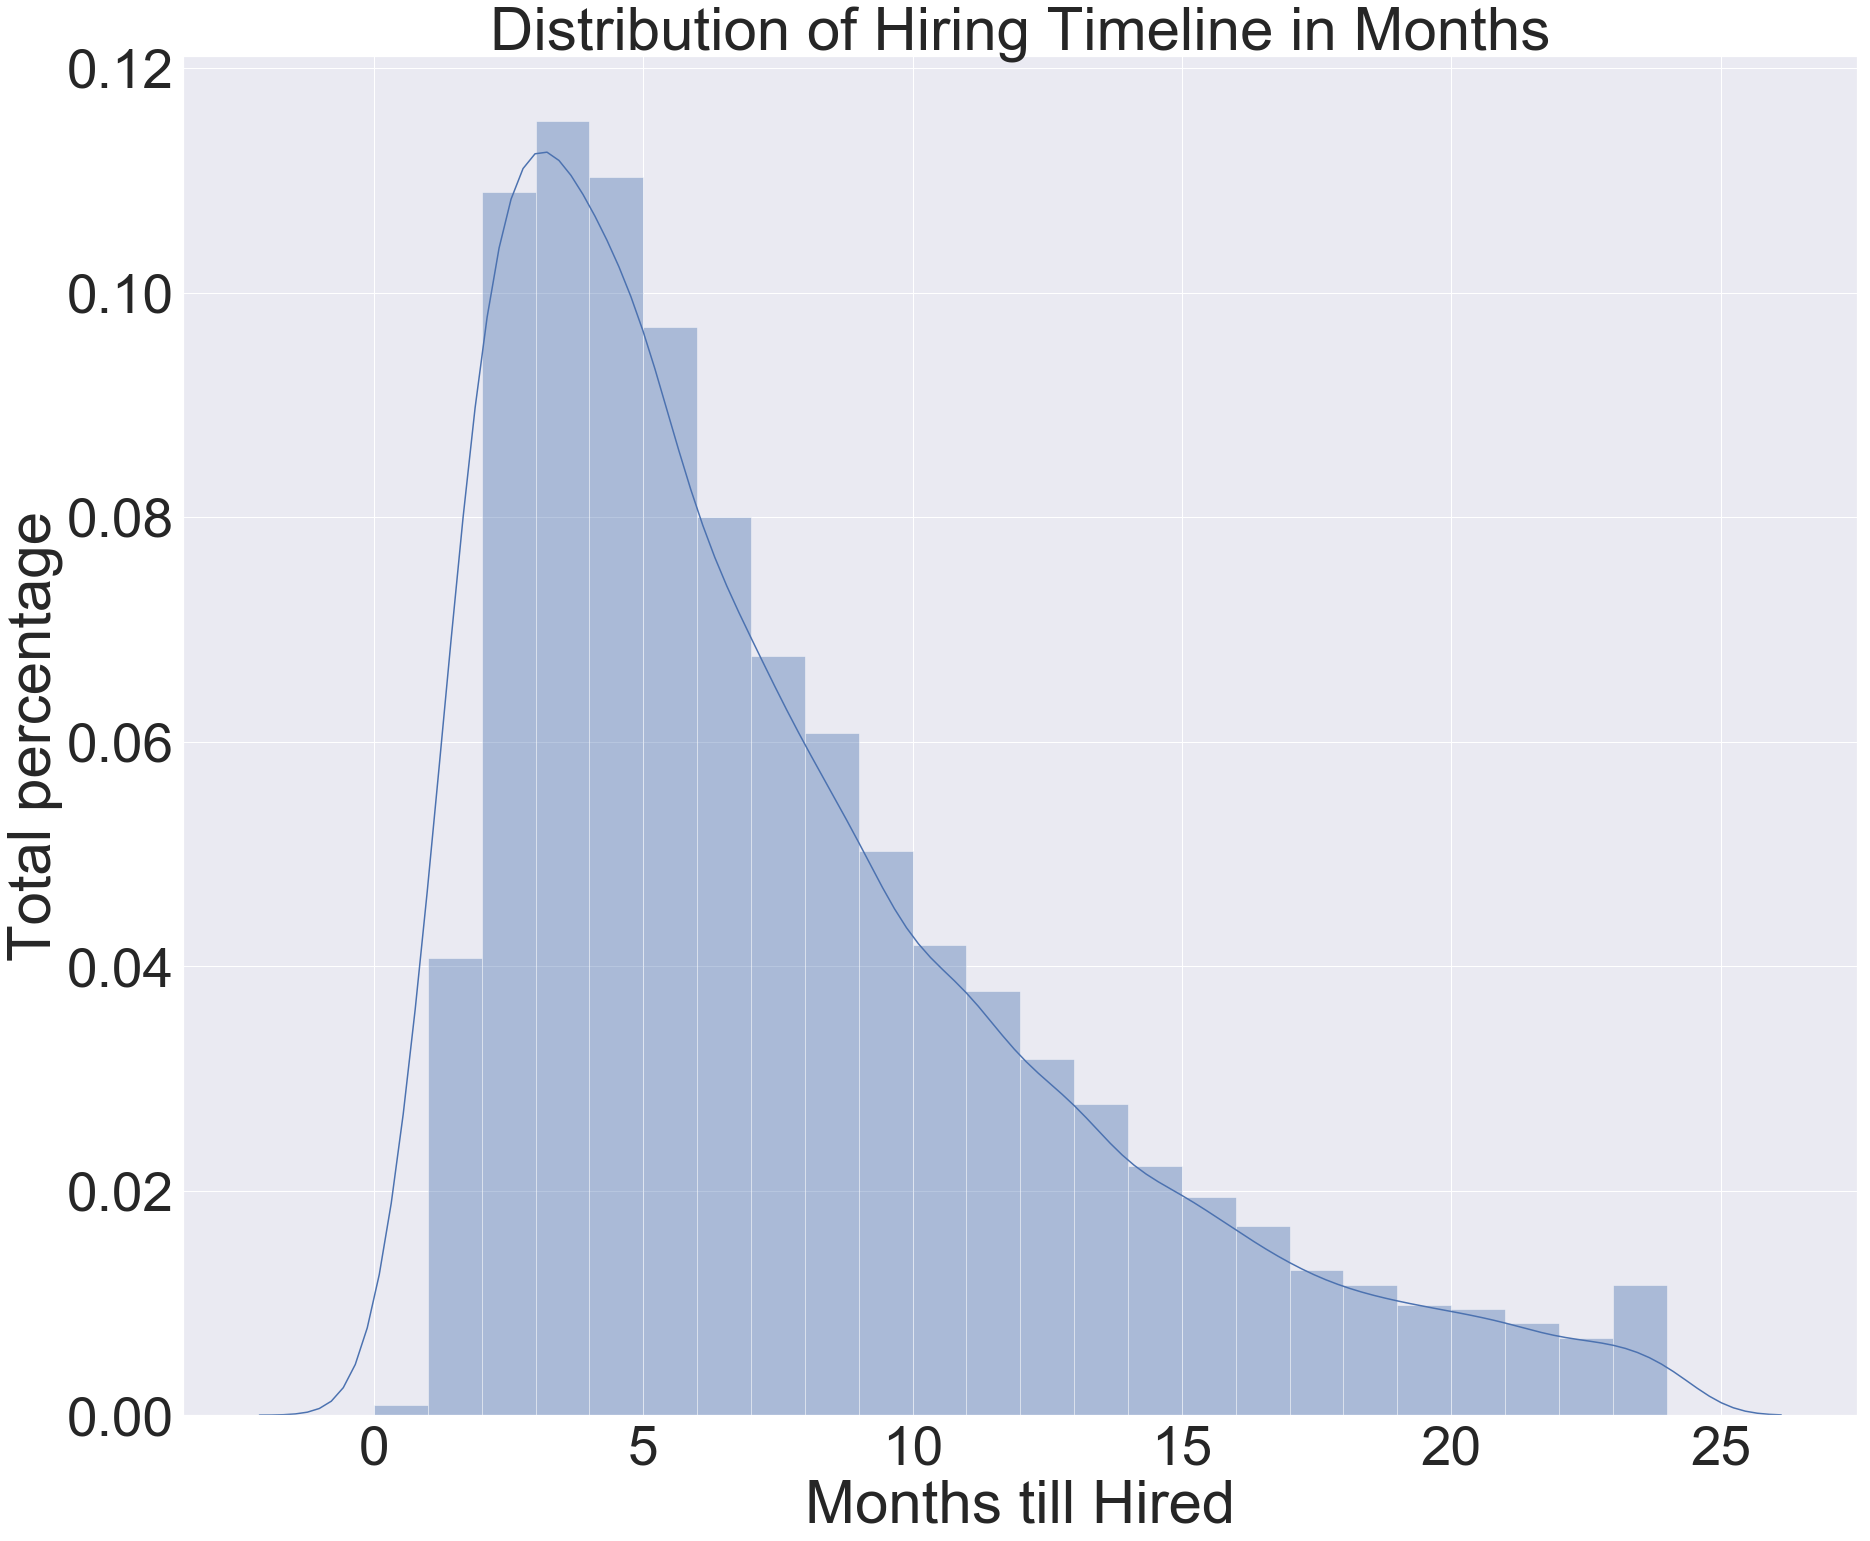

In [26]:
# graph Distribution of Hiring Timeline in Months
ax = sns.distplot(y_plt,bins=24);
ax.axes.set_title("Distribution of Hiring Timeline in Months")
ax.set_ylabel("Total percentage")
ax.set_xlabel("Months till Hired")


In [27]:
# try 4: using neural networks

X_train, X_test, y_train, y_test = train_test_split(filtered_x, filtered_y, test_size=0.1)
X_train=normalize(X_train)
X_test=normalize(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 86))

# Adding the second hidden layer
model.add(Dense(units = 64, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 10)

y_pred = model.predict(X_test)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
23235/23235 [==============================] - 6s 264us/step - loss: 22.8560
Epoch 2/10
23235/23235 [==============================] - 5s 201us/step - loss: 20.9189
Epoch 3/10
23235/23235 [==============================] - 4s 175us/step - loss: 20.5817
Epoch 4/10
23235/23235 [==============================] - 4s 157us/step - loss: 20.3432
Epoch 5/10
23235/23235 [==============================] - 4s 173us/step - loss: 20.2567
Epoch 6/10
23235/23235 [==============================] - 4s 157us/step - loss: 20.1410
Epoch 7/10
23235/23235 [==============================] - 5s 210us/step - loss: 20.0768
Epoch 8/10
23235/23235 [==============================] - 5s 207us/step - loss: 19.9927
Epoch 9/10
23235/23235 [==============================] - 4s 165us/step - loss: 19.9361
Epoch 10/10
23235/23235 [==============================] - 4s 151us/step - loss: 19.8737

In [28]:
print("neural net accuracy:")

time_diff=[]
for i in range(len(y_pred)):
    time_diff.append(abs(y_test[i] - y_pred[i]))

for i in range(1,12):
    print("month range:", i, " prediction accuracy:", str(round(accuracy(i)*100, 3))+"%")
    

neural net accuracy:
month range: 1  prediction accuracy: 15.647%
month range: 2  prediction accuracy: 31.952%
month range: 3  prediction accuracy: 49.032%
month range: 4  prediction accuracy: 63.943%
month range: 5  prediction accuracy: 76.569%
month range: 6  prediction accuracy: 85.012%
month range: 7  prediction accuracy: 89.969%
month range: 8  prediction accuracy: 93.029%
month range: 9  prediction accuracy: 94.423%
month range: 10  prediction accuracy: 95.895%
month range: 11  prediction accuracy: 96.863%


In [29]:
# try 5: using KNN

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train) 
pred = knn.predict(X_test)
time_diff=[]

print("KNN accuracy")
for i in range(len(pred)):
    time_diff.append(abs(y_test[i] - round(pred[i],0)))

for i in range(1,13):
    print("month range:", i, " prediction accuracy:", str(round(accuracy(i)*100, 3))+"%")
    

KNN accuracy
month range: 1  prediction accuracy: 29.744%
month range: 2  prediction accuracy: 44.423%
month range: 3  prediction accuracy: 56.235%
month range: 4  prediction accuracy: 64.601%
month range: 5  prediction accuracy: 72.27%
month range: 6  prediction accuracy: 77.537%
month range: 7  prediction accuracy: 81.216%
month range: 8  prediction accuracy: 85.05%
month range: 9  prediction accuracy: 87.413%
month range: 10  prediction accuracy: 90.124%
month range: 11  prediction accuracy: 92.177%
month range: 12  prediction accuracy: 94.268%


In [30]:
# baseline predictor of predicting 7 months

print("baseline model accuracy")
time_diff = []
for i in range(len(y_predict)):
    time_diff.append(abs(Y[i] - 7)) 
for i in range(1, 13):
    print("month range:", i, " prediction accuracy:", accuracy(i))
    

baseline model accuracy
month range: 1  prediction accuracy: 0.08532818532818531
month range: 2  prediction accuracy: 0.2976833976833977
month range: 3  prediction accuracy: 0.42895752895752903
month range: 4  prediction accuracy: 0.5911196911196911
month range: 5  prediction accuracy: 0.6606177606177607
month range: 6  prediction accuracy: 0.6876447876447876
month range: 7  prediction accuracy: 0.7223938223938224
month range: 8  prediction accuracy: 0.7455598455598456
month range: 9  prediction accuracy: 0.7571428571428571
month range: 10  prediction accuracy: 0.7648648648648649
month range: 11  prediction accuracy: 0.7687258687258688
month range: 12  prediction accuracy: 0.788030888030888
